# 用逻辑回归实现Neural Network（神经网络）的数字识别

* 选用kernel learning_dl
~~~
conda activate learning_dl 

# conda remove --name learning_dl --all
~~~

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告
# import tensorflow as tf

print("finish import module!!!")

finish import module!!!


(5000, 400)
(5000,)


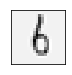

The label of this figure is 6


In [2]:
#首先先将数据读入并且可视化看看

def load_data(path, transpose=True):
    data = sio.loadmat(path)#读取mat文件
    y = data.get('y')  # (5000,1)
    y = y.reshape(y.shape[0])  # make it back to column vector

    X = data.get('X')  # (5000,400)

    if transpose:
        # for this dataset, you need a transpose to get the orientation right
        X = np.array([im.reshape((20, 20)).T for im in X])

        # and I flat the image again to preserve the vector presentation
        X = np.array([im.reshape(400) for im in X])

    return X, y

# 绘图函数，把数据画出来
def plot_an_image(image):
#     """
#     image : (400,)
#     """
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.matshow(image.reshape((20, 20)), cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))  # just get rid of ticks
    plt.yticks(np.array([]))

X, y = load_data('ex3data1.mat')

print(X.shape)
print(y.shape)

pick_one = np.random.randint(0, 5000)#随机选取一个数据
plot_an_image(X[pick_one, :])
plt.show()
print('The label of this figure is {}'.format(y[pick_one]))

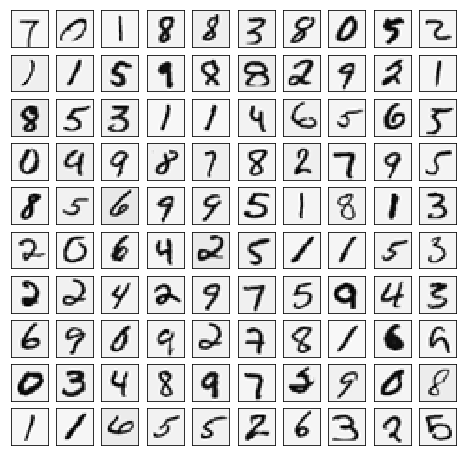

In [3]:
#绘制100个数据
def plot_100_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    size = int(np.sqrt(X.shape[1]))

    # sample 100 image, reshape, reorg it
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400(随机选取100个数据)
    sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))  
            #绘图函数，画100张图片

plot_100_image(X)
plt.show()

In [4]:
# add intercept=1 for x0
raw_X, raw_y = load_data('ex3data1.mat') #这里的raw_X是原始的X，没有插入第一列的1
# X (5000, 400) => (5000, 401)，插入第一列为1这样可以把bias也当作一个theta来处理
X = np.insert(raw_X, 0, values=np.ones(raw_X.shape[0]), axis=1)#插入了第一列（全部为1）
print(raw_X.shape,"=>",X.shape)

(5000, 400) => (5000, 401)


In [5]:
# y have 10 categories here. 1..10, they represent digit 0 as category 10 because matlab index start at 1
# I'll ditit 0, index 0 again
y_matrix = []

for k in range(1, 11):
    y_matrix.append((raw_y == k).astype(int))

# last one is k==10, it's digit 0, bring it to the first position，最后一列k=10，都是0，把最后一列放到第一列
y_matrix = [y_matrix[-1]] + y_matrix[:-1]
y = np.array(y_matrix)

y.shape

# 扩展 5000*1 到 5000*10
#     比如 y=10 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]: ndarray
#     """

(10, 5000)

In [8]:
# 训练逻辑回归
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 定义逻辑回归的代价函数
def cost(theta, X, y):
    ''' cost fn is -l(theta) for you to minimize'''
    return np.mean(-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta)))

# 正则化代价函数
def regularized_cost(theta, X, y, l=1):
    '''you don't penalize theta_0'''
    theta_j1_to_n = theta[1:]
    regularized_term = (l / (2 * len(X))) * np.power(theta_j1_to_n, 2).sum()

    return cost(theta, X, y) + regularized_term

# 定义梯度函数
def gradient(theta, X, y):
    '''just 1 batch gradient'''
    return (1 / len(X)) * X.T @ (sigmoid(X @ theta) - y)

# 正则化梯度函数
def regularized_gradient(theta, X, y, l=1):
    '''still, leave theta_0 alone'''
    theta_j1_to_n = theta[1:]
    regularized_theta = (l / len(X)) * theta_j1_to_n

    # by doing this, no offset is on theta_0
    regularized_term = np.concatenate([np.array([0]), regularized_theta])

    return gradient(theta, X, y) + regularized_term

# 逻辑回归
def logistic_regression(X, y, l=1):
    """generalized logistic regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    # init theta
    theta = np.zeros(X.shape[1])#初始化权重theta

    # train it（采用opt训练）
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    # get trained parameters
    final_theta = res.x

    return final_theta

# 输入数据，并且训练分类器
final_theta = logistic_regression(X, y[0])

print("final_theta:",final_theta, "with size is:",final_theta.shape)

# 预测函数
def predict(x, theta):
    prob = sigmoid(x @ theta)
    return (prob >= 0.5).astype(int)

y_pred = predict(X, final_theta)
print('Accuracy={}'.format(np.mean(y[0] == y_pred)))#计算准确率

final_theta: [-5.40446075e+00  0.00000000e+00 -1.69372405e-09  1.53021271e-08
  5.20208642e-08 -1.22674188e-05 -6.71896930e-05  2.15070604e-03
  2.79749540e-03  1.02532013e-03  3.05470081e-04 -3.68196922e-03
 -7.88285813e-03  2.60618280e-02  1.60598664e-02  4.14854713e-05
  4.88387804e-04  1.85551944e-04 -2.19039418e-05 -3.00894411e-08
  0.00000000e+00  0.00000000e+00 -8.74496158e-06  5.47016309e-05
  4.72463420e-04  6.69056090e-04  2.05477180e-03 -1.69784100e-02
 -2.32617439e-02 -1.39608818e-02 -5.63052571e-02 -6.43200850e-02
 -1.97130671e-01 -3.70962455e-01 -1.82116559e-01 -3.38772772e-02
 -8.24286830e-03 -3.03869071e-04 -4.29698957e-03  1.81780078e-04
 -9.25299871e-06 -2.29485046e-09 -1.47355448e-05 -4.67844649e-05
  2.04177888e-03  5.85821200e-03 -1.09648325e-02 -1.89576841e-01
 -4.63717618e-01 -6.77797954e-01 -3.48368903e-01  4.36678956e-03
 -4.61058010e-01 -2.86156678e-01 -1.30740644e-01 -1.72996803e-01
 -3.46814449e-01 -8.41380855e-02  3.83511107e-02  1.94109044e-03
 -4.21731489